# Kmeans++

Implementation of Kmean++ algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import imageio.v3 as iio
import random
from scipy.spatial.distance import euclidean
from numba import jit, njit, prange
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
class Kmeans_PP:
    def __init__(self, file_path, grayscale=True, clusters=5, epsilon = 0.2):
        self.__img = None
        if not os.path.exists(file_path):
            raise Exception("Invalid Path. Does not Exist")
        self.__img = iio.imread(file_path)
        if grayscale == True:
            self.cmap = 'gray'
        else:
            self.cmap = "viridis"
        self.__clusters = clusters
        self.__epsilon = epsilon
        self.__cmap = self.__make_label_colormap()
    
    def __make_label_colormap(self):
        """
            Create a color map for visualizing the labels themselves, such that the segment boundaries become more visible, unlike
            in the visualization using the cluster peak colors.
        """
        rng = np.random.RandomState(2)
        values = np.linspace(0, 1, 20)
        colors = plt.cm.get_cmap('hsv')(values)
        rng.shuffle(colors)
        return matplotlib.colors.ListedColormap(colors)
    
    def segment(self):
        height, width, depth = self.__img.shape
        centers = list()
        
        # Randomly initialize centers
        for i in range(self.__clusters):
            x, y = random.randint(0, height-1), random.randint(0, width-1)
            centers.append(self.__img[x, y, :])
        centers = np.array(centers)
        
        # Create a matrix where each pixel will be assigned a nearest center based on RGB Color channel
        segmented_pixels = np.zeros((self.__img.shape[0], self.__img.shape[1]))
        flag = True

        # Numba accelerated function to find the cluster centers
        @jit(cache=True, parallel=True)
        def find_centers():
            # Assign all pixels to centers
            for x in prange(self.__img.shape[0]):
                for y in range(self.__img.shape[1]):
                    val = self.__img[x, y, :]
                    min_ = np.infty
                    for idx, center in enumerate(centers):
                        dist = euclidean(val, center)
                        # Store the index of the center with the minimum distance to the given pixel
                        if dist < min_:
                            segmented_pixels[x, y] = idx
                            min_ = dist
        while(flag):
            find_centers()
            
            new_centers = []
            # Re compute the mean of the pixels assigned to a given center
            for idx, center in enumerate(centers):
                assigned_pixels = segmented_pixels == idx
                colored_mean_across_three_channels = np.mean(self.__img[assigned_pixels, :], axis = 0)
                new_centers.append(colored_mean_across_three_channels)
            new_centers = np.array(new_centers)
            
            # Take the difference of centers in current and last iteration to compare with cut-off threshold
            diff = np.abs(centers - new_centers)
            
            for c in diff:
                if np.any(c > self.__epsilon):
                    # Continue calculating
                    break;
            else:
                flag = False
            centers = new_centers
        # Display the new clustered image
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.set_title('Kmeans++')
        ax.imshow(segmented_pixels, cmap=self.__cmap)

In [4]:
color_seg_fast = Kmeans_PP("./data/palace.jpg", clusters = 6, epsilon = 0.1)

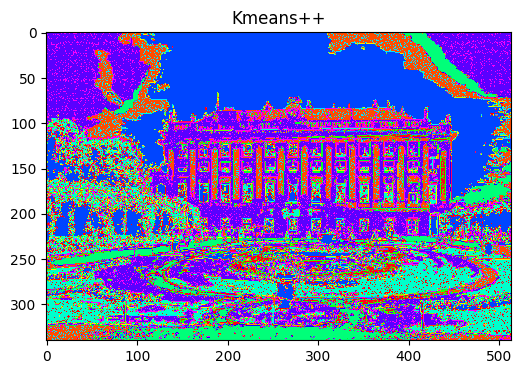

In [5]:
res = color_seg_fast.segment()